In [20]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds, eigs
import itertools

# function that imports the data
def import_data(filename):
    file = open("./jr_data/"+filename,'r')
    lines = file.readlines()
    lst = []
    for line in lines:
        i,j,r = line.split(',')
        lst.append([int(i)-1,int(j)-1,float(r)])
    return lst

# converts the list to a n by m matrix, where the list consists of n items each of size m
def list_to_matrix(n,m,lst):
    R = -11*np.ones((n,m))
    for i in range(len(lst)):
        R[int(lst[i][0])][int(lst[i][1])] = lst[i][2]
    return R

# given a matrix L, returns an index (i,j) that contains the minimum element
def min_index(L):
    minrowindex = []
    minrow = []
    for i in range(len(L)):
        minrowindex.append(np.argmin(np.array(L[i])))
        minrow.append(min(L[i]))
    return (np.argmin(np.array(minrow)),minrowindex[np.argmin(np.array(minrow))])

def square_error(U,V,R):
    n = R.shape[0]
    m = R.shape[1]
    size = 0
    error = 0
    for i in range(n):
        for j in range(m):
            if(R[i][j] != -11):
                error = error + (np.dot(U[i],V[j])-R[i][j])**2
                size = size + 1
    return error/size

def absolute_error(U,V,R):
    n = R.shape[0]
    m = R.shape[1]
    error = 0
    for i in range(n):
        ind_size = 0
        ind_error = 0
        for j in range(m):
            if(R[i][j] != -11):
                ind_error = ind_error + np.absolute(np.dot(U[i],V[j])-R[i][j])
                ind_size = ind_size + 1
        error = error + ind_error/ind_size
    return error/n

# function on which the prediction corresponds to outputting the average
def average_predict(R):
    n = R.shape[0]
    m = R.shape[1]
    R = replace_zero(R)
    return np.ones((n,1)), np.reshape(np.sum(R,axis = 0)/n,(m,1))
    
# all -11 entries are replaced with a 0
def replace_zero(R):
    n = R.shape[0]
    m = R.shape[1]
    for i in range(n):
        for j in range(m):
            if(R[i][j] == -11):
                R[i][j] = 0
    return R

m = 500
n = 1000
train = import_data("train.txt")
test = import_data("test.txt")
R_train = list_to_matrix(n,m,train)
R_test = list_to_matrix(n,m,test)


#Average Prediction
U,V = average_predict(R_train)
test_error_sqr = square_error(U,V,R_test)
test_error_abs = absolute_error(U,V,R_test)

print('Square test error =',test_error_sqr,', absolute test error =',test_error_abs)



#SVD with error not counting zeros

4.0502161509427355 1.609103673489961


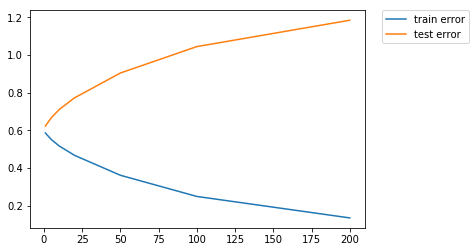

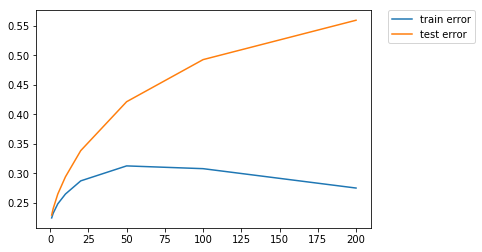

In [13]:
#SVD with counting zeros
R_train_zero = replace_zero(R_train) 
R_test_zero = replace_zero(R_test)

user_train = R_train_zero
jokes_train = np.transpose(R_train_zero)

sqr_train = []
sqr_test = []
abs_train = []
abs_test = []
for k in [1, 2, 5, 10, 20, 50, 100, 200]:
    user_mean = np.reshape(np.sum(user_train,axis=0)/user_train.shape[0],(user_train.shape[1],1))
    user = user_train - np.matmul(np.ones((user_train.shape[0],1)),np.transpose(user_mean))
    
    # computing the svd after de-meaning the data
    u, s, v = svds(user,k=k)
    user_U = u * s
    joke_V = np.transpose(v)
    
    #user_U and joke_V are used foer the prediction
    sqrtr_error = square_error(user_U,joke_V,R_train)
    sqrtst_error = square_error(user_U,joke_V,R_test)
    sqr_train.append(sqrtr_error)
    sqr_test.append(sqrtst_error)
    
    abstr_error = absolute_error(user_U,joke_V,R_train)
    abstst_error = absolute_error(user_U,joke_V,R_test)
    abs_train.append(abstr_error)
    abs_test.append(abstst_error)

# plot the findings

# dimension vs square error

plt.figure(1)
plt.plot([1, 2, 5, 10, 20, 50, 100, 200],sqr_train,label = "train error")
plt.plot([1, 2, 5, 10, 20, 50, 100, 200],sqr_test,label = "test error")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('dimension')
plt.ylabel('square error')
plt.show();

# dimension vs absolute error

plt.figure(2)
plt.plot([1, 2, 5, 10, 20, 50, 100, 200],abs_train,label = "train error")
plt.plot([1, 2, 5, 10, 20, 50, 100, 200],abs_test,label = "test error")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('dimension')
plt.ylabel('absolute error')
plt.show();

In [30]:
# we now use an alternate minimization scheme

def obj_fun(U,V,R,lmd):
    n = R.shape[0]
    m = R.shape[1]
    error = 0
    for i in range(n):
        for j in range(m):
            if(R[i][j] != -11):
                error = error + (np.dot(U[i],V[j])-R[i][j])**2
    return error + lmd* np.sum(U*U) + lmd*np.sum(V*V)

# function that finds U,V using the alternate minimization scheme where the objective is also parameterized by a lambda
def alternate_minimize(R,lmd,k):
    n = R.shape[0]
    m = R.shape[1]
    U = np.random.normal(0,1,(n,k))
    V = np.random.normal(0,1,(m,k))
    fnval = obj_fun(U,V,R,lmd)
    diff = 0.1
    while diff >= 0.01:
        for i in range(n):
            ind = R[i] != -11
            A = np.matmul(np.transpose(V[ind,:]),V[ind,:]) + lmd* np.identity(k)
            b = np.matmul(R[i,:][ind],V[ind,:])
            U[i] = linalg.solve(A,b)
        for j in range(m):
            ind = R[:,j] != -11
            A = np.matmul(np.transpose(U[ind,:]),U[ind,:]) + lmd*np.identity(k)
            b = np.matmul(R[:,j][ind],U[ind,:])
        
        fnval_new = obj_fun(U,V,R,lmd) 
        diff = np.absolute(fnval - fnval_new)
        fnval = fnval_new
    return U,V

#cross validation
def cross_validate(n,m,train):
    perm = np.random.permutation(len(train))
    trn = np.reshape(train,(len(train),3))
    
    R_trn = list_to_matrix(n,m,trn[perm[:int(0.9*len(train))],:])
    R_tst = list_to_matrix(n,m,trn[perm[int(0.9*len(train)):],:])

    klst = []
    dlst = [1, 2, 5, 10, 20, 50, 100, 200]
    for k in dlst:
        lmd = 1000
        lmdlst = []
        errlst = []
        while lmd >= 0.001:
            U,V = alternate_minimize(R_trn,lmd,k)
            lmdlst.append(lmd)
            errlst.append(square_error(U,V,R_tst))
            lmd = lmd/1.5
        klst.append(errlst)

    a,b = min_index(klst)
    return dlst[a],lmdlst[b]

k,lmd = cross_validate(n,m,train)
U,V = alternate_minimize(R_train,lmd,k)
print(square_error(U,V,R_test))

#print("Desired Parameters")
#print(d[a],lmdlst[b])

#plt.figure(3)
#plt.plot(lmdlst,errlst,label = "test error")
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.xscale('log')
#plt.show();
#U,V = alternate_minimize(R_train,0.1,2)
#print(U,V)

5.05259819648173


In [7]:
a = "1,2,3"
x,y,z = a.split(',')
print(x,y,z)

1 2 3


In [14]:
A = np.ones((3,2))
print(np.sum(A,axis=0))
print(A[:,0])

[3. 3.]
[1. 1. 1.]


In [23]:
n = 1000
print(int(0.9*n))

900


In [13]:
a = [[1,1],[2,1],[3,1]]
a = np.reshape(a,(len(a),2))
print(a)
ind = np.random.permutation(3)[:1]
print(ind)
print(a[ind,:])

[[1 1]
 [2 1]
 [3 1]]
[1]
[[2 1]]


In [31]:
print(k,lmd)

1 131.68724279835388
